In [9]:
import constants as c
import tensorflow as tf
import numpy as np
import pandas as pd
from transformers import BertTokenizer, GPT2Tokenizer, TFBertModel
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dense
from tensorflow.keras.models import Model
import os
import pickle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv('data/full_dataset.csv')

In [5]:
data = df

In [6]:
RECIPE_START_TOKEN = c.RECIPE_START_TOKEN
RECIPE_END_TOKEN = c.RECIPE_END_TOKEN

TITLE_START_TOKEN = c.TITLE_START_TOKEN
TITLE_END_TOKEN = c.TITLE_END_TOKEN

NER_START_TOKEN = c.NER_START_TOKEN
NER_END_TOKEN = c.NER_END_TOKEN
NER_NEXT_TOKEN = c.NER_NEXT_TOKEN

INGREDIENTS_START_TOKEN = c.INGREDIENTS_START_TOKEN
INGREDIENTS_END_TOKEN = c.INGREDIENTS_END_TOKEN
INGREDIENTS_NEXT_TOKEN = c.INGREDIENTS_NEXT_TOKEN

INSTRUCTIONS_START_TOKEN = c.INSTRUCTIONS_START_TOKEN
INSTRUCTIONS_END_TOKEN = c.INSTRUCTIONS_END_TOKEN
INSTRUCTIONS_NEXT_TOKEN = c.INSTRUCTIONS_NEXT_TOKEN


MIN_RECIPE_LENGTH = c.MIN_RECIPE_LENGTH
MAX_RECIPE_LENGTH = c.MAX_RECIPE_LENGTH

In [7]:
def recipe_to_string(title, ingr, instr, ner):
    # This string is presented as a part of recipes so we need to clean it up.
    
    title = title
    ingredients = ingr.replace("]", "").replace("[", "").replace('"', "").split(", ")
    instructions = [instruction.replace('"', "") for instruction in instr.replace("]", "").replace("[", " ").split('",')]
    ners = ner.replace("]", "").replace("[", "").replace('"', "").split(", ")
    
    ingredients_string = f'{INGREDIENTS_NEXT_TOKEN}'.join(ingredients)
    instructions_string = f'{INSTRUCTIONS_NEXT_TOKEN}'.join(instructions)
    ners_string = f'{NER_NEXT_TOKEN}'.join(ners)
            
    ner_final_string = f'{NER_START_TOKEN}{ners_string}{NER_END_TOKEN}'
    title_final_string = f'{TITLE_START_TOKEN}{title}{TITLE_END_TOKEN}'
    instructions_final_string = f'{INSTRUCTIONS_START_TOKEN}{instructions_string}{INSTRUCTIONS_END_TOKEN}'
    ingredients_final_string = f'{INGREDIENTS_START_TOKEN}{ingredients_string}{INGREDIENTS_END_TOKEN}'
    
    recipe_final_string = f'{RECIPE_START_TOKEN}{ner_final_string}{ingredients_final_string}{instructions_final_string}{title_final_string}{RECIPE_END_TOKEN}'
    
    return recipe_final_string

titles = data["title"]
ingredients = data["ingredients"]
directions = data["directions"]
ner_labels = data["NER"]

dataset_stringified = [recipe_to_string(title, ingr, instr, ner) for title, ingr, instr, ner in zip(titles, ingredients, directions, ner_labels)]

['<RECIPE_START>',
 '<NER_START>',
 'beef',
 '<NER_NEXT>',
 'chicken',
 'breasts',
 '<NER_NEXT>',
 'cream',
 'of',
 'mushroom',
 'soup',
 '<NER_NEXT>',
 'sour',
 'cream',
 '<NER_END>',
 '<INGREDIENTS_START>',
 '1',
 'small',
 'jar',
 'chipped',
 'beef',
 '<INGREDIENTS_NEXT>',
 'cut',
 'up',
 '<INGREDIENTS_NEXT>',
 '4',
 'boned',
 'chicken',
 'breasts',
 '<INGREDIENTS_NEXT>',
 '1',
 'can',
 'cream',
 'of',
 'mushroom',
 'soup',
 '<INGREDIENTS_NEXT>',
 '1',
 'carton',
 'sour',
 'cream',
 '<INGREDIENTS_END>',
 '<INSTRUCTIONS_START>',
 'Place',
 'chipped',
 'beef',
 'on',
 'bottom',
 'of',
 'baking',
 'dish.',
 '<INSTRUCTIONS_NEXT>',
 'Place',
 'chicken',
 'on',
 'top',
 'of',
 'beef.',
 '<INSTRUCTIONS_NEXT>',
 'Mix',
 'soup',
 'and',
 'cream',
 'together;',
 'pour',
 'over',
 'chicken.',
 'Bake,',
 'uncovered,',
 'at',
 '275\\u00b0',
 'for',
 '3',
 'hours.',
 '<INSTRUCTIONS_END>',
 '<TITLE_START>',
 'Jewell',
 "Ball'S",
 'Chicken',
 '<TITLE_END>',
 '<RECIPE_END>']

In [20]:
recipes_lengths = []
for recipe_text in dataset_stringified:
    recipes_lengths.append(len((recipe_text).split(" ")))

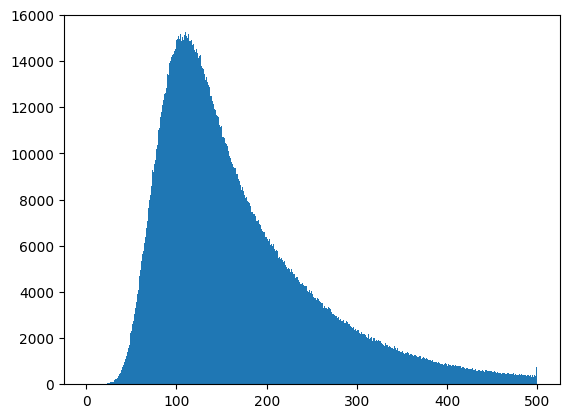

In [24]:
plt.hist(recipes_lengths, bins=500, range=(0, 500))
plt.show()

In [6]:
print(dataset_stringified[0])

<RECIPE_START> <NER_START> brown sugar <NER_NEXT> milk <NER_NEXT> vanilla <NER_NEXT> nuts <NER_NEXT> butter <NER_NEXT> bite size shredded rice biscuits <NER_END> <INGREDIENTS_START> 1 c. firmly packed brown sugar <INGREDIENTS_NEXT> 1/2 c. evaporated milk <INGREDIENTS_NEXT> 1/2 tsp. vanilla <INGREDIENTS_NEXT> 1/2 c. broken nuts (pecans) <INGREDIENTS_NEXT> 2 Tbsp. butter or margarine <INGREDIENTS_NEXT> 3 1/2 c. bite size shredded rice biscuits <INGREDIENTS_END> <INSTRUCTIONS_START> In a heavy 2-quart saucepan, mix brown sugar, nuts, evaporated milk and butter or margarine. <INSTRUCTIONS_NEXT> Stir over medium heat until mixture bubbles all over top. <INSTRUCTIONS_NEXT> Boil and stir 5 minutes more. Take off heat. <INSTRUCTIONS_NEXT> Stir in vanilla and cereal; mix well. <INSTRUCTIONS_NEXT> Using 2 teaspoons, drop and shape into 30 clusters on wax paper. <INSTRUCTIONS_NEXT> Let stand until firm, about 30 minutes. <INSTRUCTIONS_END> <TITLE_START> No-Bake Nut Cookies <TITLE_END> <RECIPE_END

In [7]:
dataset_stringified_joint = " ".join(dataset_stringified)
dataset_stringified_joint[:1000]

'<RECIPE_START> <NER_START> brown sugar <NER_NEXT> milk <NER_NEXT> vanilla <NER_NEXT> nuts <NER_NEXT> butter <NER_NEXT> bite size shredded rice biscuits <NER_END> <INGREDIENTS_START> 1 c. firmly packed brown sugar <INGREDIENTS_NEXT> 1/2 c. evaporated milk <INGREDIENTS_NEXT> 1/2 tsp. vanilla <INGREDIENTS_NEXT> 1/2 c. broken nuts (pecans) <INGREDIENTS_NEXT> 2 Tbsp. butter or margarine <INGREDIENTS_NEXT> 3 1/2 c. bite size shredded rice biscuits <INGREDIENTS_END> <INSTRUCTIONS_START> In a heavy 2-quart saucepan, mix brown sugar, nuts, evaporated milk and butter or margarine. <INSTRUCTIONS_NEXT> Stir over medium heat until mixture bubbles all over top. <INSTRUCTIONS_NEXT> Boil and stir 5 minutes more. Take off heat. <INSTRUCTIONS_NEXT> Stir in vanilla and cereal; mix well. <INSTRUCTIONS_NEXT> Using 2 teaspoons, drop and shape into 30 clusters on wax paper. <INSTRUCTIONS_NEXT> Let stand until firm, about 30 minutes. <INSTRUCTIONS_END> <TITLE_START> No-Bake Nut Cookies <TITLE_END> <RECIPE_EN

In [8]:
len(dataset_stringified_joint)

3031984438

In [9]:
with open(f'data/all/stringified.txt', 'w', encoding='utf-8') as f:
    f.write(dataset_stringified_joint)

In [10]:
with open(f'data/train_{number_of_recipes}.txt', 'w', encoding='utf-8') as f:
    f.write(dataset_filtered_train_joint)

NameError: name 'number_of_recipes' is not defined

In [ ]:
with open(f'data/test_{number_of_recipes}.txt', 'w', encoding='utf-8') as f:
    f.write(dataset_filtered_test_joint)